# 1. Overview

Let's first import the modules needed for this sentiment analysis project. The original data for this project could be downloaded in here:

[Bag of Words Meets Bags of Popcorn](https://www.kaggle.com/c/word2vec-nlp-tutorial/data)

In [22]:
import re
import time
import logging
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import nltk
from nltk import data
from nltk.corpus import stopwords
from nltk.stem.lancaster import LancasterStemmer

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report,confusion_matrix, roc_curve, auc

import tensorflow as tf

import gensim
from gensim.models import Word2Vec

First, load the dataset. We use pandas to read the tab delimited file.

In [2]:
""""
header=0: indicates that the first line of the file contains column names
"delimiter=\t": indicates that the fields are separated by tabs
quoting=3: tells Python to ignore doubled quotes
"""

labeled_train = pd.read_csv("labeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
unlabeled_train = pd.read_csv("unlabeledTrainData.tsv", header=0, delimiter="\t", quoting=3)
test_data = pd.read_csv("testData.tsv", header=0, delimiter="\t", quoting=3)

In [3]:
labeled_train.columns

Index(['id', 'sentiment', 'review'], dtype='object')

As a remainder, the following code shows the first review given by a user. From the review, we could see HTML tags, abbreviations, punctuations. We need to clean the data before putting it to a machine learning model.

In [4]:
labeled_train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

# 2. Data Cleaning

In this part, we are going to do the text data preprocessing, which mainly includes deleting the punctuations, removing HTML tags, removing non-letters, etc. The following function shows how to finish these data cleaning steps.

In [5]:
def review_to_words(raw_review, remove_stopwords = False ):

    # 1. Remove HTML
    try:
        review_text = BeautifulSoup(raw_review).get_text() 
    except TypeError:
        # Here if we just use the beautifulsoup to clean the data, we notice that some texts just become none 
        # and it will cause TypeError. Hence, we just add a value to this None case.
        review_text = "None"
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    # 4. Remove stop words
    # In Python, searching a set is much faster than searchin a list, so convert the stop words to a set
    if remove_stopwords:
        stops = set(stopwords.words("english"))                  
        words = [w for w in words if not w in stops]   
    #
    # 5. Join the words back into one string separated by space, and return the result.
    return words

In [6]:
clean_review = review_to_words( labeled_train["review"][0] )
print(clean_review)

['with', 'all', 'this', 'stuff', 'going', 'down', 'at', 'the', 'moment', 'with', 'mj', 'i', 've', 'started', 'listening', 'to', 'his', 'music', 'watching', 'the', 'odd', 'documentary', 'here', 'and', 'there', 'watched', 'the', 'wiz', 'and', 'watched', 'moonwalker', 'again', 'maybe', 'i', 'just', 'want', 'to', 'get', 'a', 'certain', 'insight', 'into', 'this', 'guy', 'who', 'i', 'thought', 'was', 'really', 'cool', 'in', 'the', 'eighties', 'just', 'to', 'maybe', 'make', 'up', 'my', 'mind', 'whether', 'he', 'is', 'guilty', 'or', 'innocent', 'moonwalker', 'is', 'part', 'biography', 'part', 'feature', 'film', 'which', 'i', 'remember', 'going', 'to', 'see', 'at', 'the', 'cinema', 'when', 'it', 'was', 'originally', 'released', 'some', 'of', 'it', 'has', 'subtle', 'messages', 'about', 'mj', 's', 'feeling', 'towards', 'the', 'press', 'and', 'also', 'the', 'obvious', 'message', 'of', 'drugs', 'are', 'bad', 'm', 'kay', 'visually', 'impressive', 'but', 'of', 'course', 'this', 'is', 'all', 'about', 

f:\python\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file f:\python\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


Now we could use this function to clean all the reviews in the labeled_train, unlabeled train and test datasets.

In [7]:
# Get the number of reviews based on the dataframe column size
num_reviews = labeled_train["review"].size

# Initialize an empty list to hold the clean reviews
clean_labeled_train_reviews = []

print('Cleaning the labeled training set movie reviews...')

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 
for i in range(num_reviews):
    if ((i+1) % 1000 == 0):
        print("Review %d of %d\n" % ( i+1, num_reviews ))
    clean_labeled_train_reviews.append( review_to_words( labeled_train["review"][i] ) )

f:\python\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file f:\python\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


Cleaning the labeled training set movie reviews...
Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



In [8]:
# Get the number of reviews based on the dataframe column size
num_reviews = unlabeled_train["review"].size

# Initialize an empty list to hold the clean reviews
clean_unlabeled_train_reviews = []

print('Cleaning the unlabeled training set movie reviews...')

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 


for i in range(num_reviews):
    if ((i+1) % 1000 == 0):
        print("Review %d of %d\n" % ( i+1, num_reviews ))
    clean_unlabeled_train_reviews.append( review_to_words( unlabeled_train["review"][i] ) )

Cleaning the unlabeled training set movie reviews...


f:\python\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file f:\python\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


Review 1000 of 115764

Review 2000 of 115764

Review 3000 of 115764

Review 4000 of 115764

Review 5000 of 115764

Review 6000 of 115764

Review 7000 of 115764

Review 8000 of 115764

Review 9000 of 115764

Review 10000 of 115764

Review 11000 of 115764

Review 12000 of 115764

Review 13000 of 115764

Review 14000 of 115764

Review 15000 of 115764

Review 16000 of 115764

Review 17000 of 115764

Review 18000 of 115764

Review 19000 of 115764

Review 20000 of 115764

Review 21000 of 115764

Review 22000 of 115764

Review 23000 of 115764

Review 24000 of 115764

Review 25000 of 115764

Review 26000 of 115764

Review 27000 of 115764

Review 28000 of 115764

Review 29000 of 115764

Review 30000 of 115764

Review 31000 of 115764

Review 32000 of 115764

Review 33000 of 115764

Review 34000 of 115764

Review 35000 of 115764

Review 36000 of 115764

Review 37000 of 115764

Review 38000 of 115764

Review 39000 of 115764

Review 40000 of 115764

Review 41000 of 115764

Review 42000 of 115764

R

In [9]:
# Get the number of reviews based on the dataframe column size
num_reviews = test_data["review"].size

# Initialize an empty list to hold the clean reviews
clean_test_data_reviews = []

print('Cleaning the test dataset movie reviews...')

# Loop over each review; create an index i that goes from 0 to the length
# of the movie review list 

for i in range(num_reviews):
    if ((i+1) % 1000 == 0):
        print("Review %d of %d\n" % ( i+1, num_reviews ))
    clean_test_data_reviews.append( review_to_words( test_data["review"][i] ) )

Cleaning the test dataset movie reviews...


f:\python\lib\site-packages\bs4\__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html5lib"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 184 of the file f:\python\lib\runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "html5lib")

  markup_type=markup_type))


Review 1000 of 25000

Review 2000 of 25000

Review 3000 of 25000

Review 4000 of 25000

Review 5000 of 25000

Review 6000 of 25000

Review 7000 of 25000

Review 8000 of 25000

Review 9000 of 25000

Review 10000 of 25000

Review 11000 of 25000

Review 12000 of 25000

Review 13000 of 25000

Review 14000 of 25000

Review 15000 of 25000

Review 16000 of 25000

Review 17000 of 25000

Review 18000 of 25000

Review 19000 of 25000

Review 20000 of 25000

Review 21000 of 25000

Review 22000 of 25000

Review 23000 of 25000

Review 24000 of 25000

Review 25000 of 25000



# 3. Construct the Model

In this tutorial, we want to implement the Word2Vec model in gensim to generate the word vectors based on the labeled and unlabeled dataset. The following codes put these two datasets together in a sentence list.

In [10]:
sentences = []

print('Parsing the sentences from the labeled training set....')
start = time.time()

for review in clean_labeled_train_reviews:
    sentences.append(review)
    
print('Parsing the sentences from the unlabeled training set....')

for review in clean_unlabeled_train_reviews:
    sentences.append(review)
    
end = time.time()
duration = end - start

print("Time taken for getting all the text: ", duration, ' seconds')

Parsing the sentences from the labeled training set....
Parsing the sentences from the unlabeled training set....
Time taken for getting all the text:  0.034595489501953125  seconds


Since we have got all the words in the labeled and unlabeled dataset, we could use the word2vec model in [gensim](https://radimrehurek.com/gensim/models/word2vec.html) to generate the word vectors.

In [11]:
# Import the built-in logging module and configure it so that Word2Vec 
# creates nice output messages
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Set values for various parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 40   # Minimum word count                        
num_workers = 4       # Number of threads to run in parallel
context = 10          # Context window size                                                                                    
downsampling = 1e-3   # Downsample setting for frequent words

# Initialize and train the model (this will take some time)
print("Training model...")
start = time.time()
model = Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

# It can be helpful to create a meaningful model name and 
# save the model for later use. You can load it later using Word2Vec.load()
model_name = "300features_40minwords_10context"
model.save(model_name)

end = time.time()
duration = end - start

print("Total time for training the word vectors: ", duration, " seconds")

2018-03-12 14:56:44,816 : INFO : collecting all words and their counts
2018-03-12 14:56:44,818 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types


Training model...


2018-03-12 14:56:45,435 : INFO : PROGRESS: at sentence #10000, processed 2385575 words, keeping 51527 word types
2018-03-12 14:56:46,057 : INFO : PROGRESS: at sentence #20000, processed 4747504 words, keeping 67813 word types
2018-03-12 14:56:46,650 : INFO : PROGRESS: at sentence #30000, processed 7109778 words, keeping 81728 word types
2018-03-12 14:56:47,263 : INFO : PROGRESS: at sentence #40000, processed 9467206 words, keeping 92655 word types
2018-03-12 14:56:47,877 : INFO : PROGRESS: at sentence #50000, processed 11825236 words, keeping 99583 word types
2018-03-12 14:56:48,483 : INFO : PROGRESS: at sentence #60000, processed 14190901 words, keeping 105913 word types
2018-03-12 14:56:49,125 : INFO : PROGRESS: at sentence #70000, processed 16573274 words, keeping 111433 word types
2018-03-12 14:56:49,772 : INFO : PROGRESS: at sentence #80000, processed 18978383 words, keeping 116764 word types
2018-03-12 14:56:50,414 : INFO : PROGRESS: at sentence #90000, processed 21360809 words, 

2018-03-12 14:57:51,316 : INFO : PROGRESS: at 19.91% examples, 426076 words/s, in_qsize 7, out_qsize 0
2018-03-12 14:57:52,320 : INFO : PROGRESS: at 20.27% examples, 426373 words/s, in_qsize 7, out_qsize 0
2018-03-12 14:57:53,325 : INFO : PROGRESS: at 20.60% examples, 426036 words/s, in_qsize 8, out_qsize 0
2018-03-12 14:57:54,333 : INFO : PROGRESS: at 20.94% examples, 425673 words/s, in_qsize 8, out_qsize 0
2018-03-12 14:57:55,363 : INFO : PROGRESS: at 21.33% examples, 426327 words/s, in_qsize 8, out_qsize 0
2018-03-12 14:57:56,409 : INFO : PROGRESS: at 21.72% examples, 426742 words/s, in_qsize 5, out_qsize 2
2018-03-12 14:57:57,433 : INFO : PROGRESS: at 22.05% examples, 426271 words/s, in_qsize 7, out_qsize 0
2018-03-12 14:57:58,443 : INFO : PROGRESS: at 22.40% examples, 426146 words/s, in_qsize 7, out_qsize 0
2018-03-12 14:57:59,448 : INFO : PROGRESS: at 22.79% examples, 426791 words/s, in_qsize 8, out_qsize 0
2018-03-12 14:58:00,482 : INFO : PROGRESS: at 23.15% examples, 426614 wor

2018-03-12 14:59:12,536 : INFO : PROGRESS: at 46.72% examples, 411582 words/s, in_qsize 8, out_qsize 1
2018-03-12 14:59:13,564 : INFO : PROGRESS: at 47.03% examples, 411276 words/s, in_qsize 7, out_qsize 0
2018-03-12 14:59:14,583 : INFO : PROGRESS: at 47.34% examples, 410950 words/s, in_qsize 8, out_qsize 0
2018-03-12 14:59:15,594 : INFO : PROGRESS: at 47.66% examples, 410794 words/s, in_qsize 7, out_qsize 0
2018-03-12 14:59:16,609 : INFO : PROGRESS: at 48.00% examples, 410674 words/s, in_qsize 8, out_qsize 0
2018-03-12 14:59:17,620 : INFO : PROGRESS: at 48.31% examples, 410374 words/s, in_qsize 7, out_qsize 2
2018-03-12 14:59:18,632 : INFO : PROGRESS: at 48.61% examples, 410166 words/s, in_qsize 7, out_qsize 0
2018-03-12 14:59:19,636 : INFO : PROGRESS: at 48.96% examples, 410241 words/s, in_qsize 8, out_qsize 0
2018-03-12 14:59:20,639 : INFO : PROGRESS: at 49.31% examples, 410323 words/s, in_qsize 6, out_qsize 1
2018-03-12 14:59:21,639 : INFO : PROGRESS: at 49.66% examples, 410447 wor

2018-03-12 15:00:33,739 : INFO : PROGRESS: at 73.17% examples, 406179 words/s, in_qsize 8, out_qsize 2
2018-03-12 15:00:34,743 : INFO : PROGRESS: at 73.58% examples, 406613 words/s, in_qsize 8, out_qsize 0
2018-03-12 15:00:35,751 : INFO : PROGRESS: at 73.92% examples, 406661 words/s, in_qsize 8, out_qsize 0
2018-03-12 15:00:36,760 : INFO : PROGRESS: at 74.20% examples, 406391 words/s, in_qsize 7, out_qsize 0
2018-03-12 15:00:37,768 : INFO : PROGRESS: at 74.56% examples, 406484 words/s, in_qsize 8, out_qsize 0
2018-03-12 15:00:38,769 : INFO : PROGRESS: at 74.93% examples, 406718 words/s, in_qsize 8, out_qsize 1
2018-03-12 15:00:39,770 : INFO : PROGRESS: at 75.27% examples, 406754 words/s, in_qsize 7, out_qsize 0
2018-03-12 15:00:40,795 : INFO : PROGRESS: at 75.59% examples, 406626 words/s, in_qsize 7, out_qsize 0
2018-03-12 15:00:41,812 : INFO : PROGRESS: at 75.92% examples, 406580 words/s, in_qsize 8, out_qsize 0
2018-03-12 15:00:42,825 : INFO : PROGRESS: at 76.26% examples, 406596 wor

2018-03-12 15:01:48,520 : INFO : precomputing L2-norms of word weight vectors
2018-03-12 15:01:48,854 : INFO : saving Word2Vec object under 300features_40minwords_10context, separately None
2018-03-12 15:01:48,855 : INFO : not storing attribute syn0norm
2018-03-12 15:01:48,857 : INFO : not storing attribute cum_table
2018-03-12 15:01:50,300 : INFO : saved 300features_40minwords_10context


Total time for training the word vectors:  305.4862220287323  seconds


We have got the word vector model. To load this model, you could use the following code:

```Python
model = Word2Vec.load("300features_40minwords_10context")
```

In [12]:
model = Word2Vec.load("300features_40minwords_10context")

2018-03-12 15:01:50,313 : INFO : loading Word2Vec object from 300features_40minwords_10context
2018-03-12 15:01:50,935 : INFO : loading wv recursively from 300features_40minwords_10context.wv.* with mmap=None
2018-03-12 15:01:50,937 : INFO : setting ignored attribute syn0norm to None
2018-03-12 15:01:50,938 : INFO : setting ignored attribute cum_table to None
2018-03-12 15:01:50,940 : INFO : loaded 300features_40minwords_10context


In [13]:
def makeFeatureVec(sentence, model, num_features):
    # Function to average all of the word vectors in a given
    # paragraph
    #
    # Pre-initialize an empty numpy array (for speed)
    featureVec = np.zeros((300,),dtype="float32")
    #
    nwords = 0.
    #
    # Index2word is a list that contains the names of the words in 
    # the model's vocabulary. Convert it to a set, for speed 
    index2word_set = set(model.wv.index2word)
    # Loop over each word in the review
    for word in sentence:
        if word in index2word_set:
            nwords = nwords + 1.
            featureVec = np.add(featureVec,model[word])
    # 
    # Divide the result by the number of words to get the average
    featureVec = np.divide(featureVec,nwords)
    return featureVec

In [14]:
def getAvgFeatureVecs(reviews, model, num_features):
    # Given a set of reviews (each one a list of words), calculate 
    # the average feature vector for each one and return a 2D numpy array 
    # 
    # Initialize a counter
    counter = 0
    # 
    # Preallocate a 2D numpy array, for speed
    reviewFeatureVecs = np.zeros((len(reviews),num_features),dtype="float32")
    # 
    # Loop through the reviews
    for review in reviews:
       #
       # Print a status message every 1000th review
        if counter % 1000. == 0.:
            print("Review %d of %d" % (counter, len(reviews)))
       # 
       # Call the function (defined above) that makes average feature vectors
        reviewFeatureVecs[int(counter),] = makeFeatureVec(review, model, num_features)
       #
       # Increment the counter
        counter = counter + 1.
    return reviewFeatureVecs

In [15]:
# ****************************************************************
# Calculate average feature vectors for training and testing sets,
# using the functions we defined above. Notice that we now use stop word
# removal.
print("Creating average feature vecs for training reviews")

trainDataVecs = getAvgFeatureVecs(clean_labeled_train_reviews, model, 300)

print("Creating average feature vecs for test reviews")

testDataVecs = getAvgFeatureVecs(clean_test_data_reviews, model, 300)

Creating average feature vecs for training reviews
Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Review 17000 of 25000
Review 18000 of 25000
Review 19000 of 25000
Review 20000 of 25000
Review 21000 of 25000
Review 22000 of 25000
Review 23000 of 25000
Review 24000 of 25000
Creating average feature vecs for test reviews
Review 0 of 25000
Review 1000 of 25000
Review 2000 of 25000
Review 3000 of 25000
Review 4000 of 25000
Review 5000 of 25000
Review 6000 of 25000
Review 7000 of 25000
Review 8000 of 25000
Review 9000 of 25000
Review 10000 of 25000
Review 11000 of 25000
Review 12000 of 25000
Review 13000 of 25000
Review 14000 of 25000
Review 15000 of 25000
Review 16000 of 25000
Revi

After getting the word vectors, we could first run a warm-up model: random forest and see how well it performs.

In [16]:
# Fit a random forest to the training data, using 100 trees
forest = RandomForestClassifier(n_estimators = 100)

print("Fitting a random forest to labeled training data...")
forest = forest.fit( trainDataVecs, labeled_train["sentiment"] )

# Test & extract results 
result = forest.predict( testDataVecs )

# Write the test results 
output = pd.DataFrame( data={"id":test_data["id"], "sentiment":result} )
output.to_csv( "Word2Vec_AverageVectors.csv", index=False, quoting=3 )

Fitting a random forest to labeled training data...


I run this model two times the result is given below.

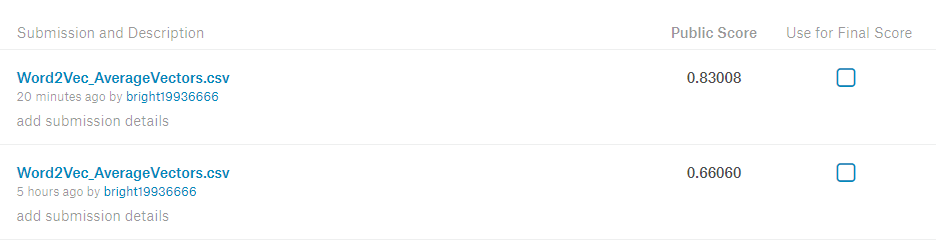

It seems that the model we just constructed does not perform stably. In my view, there are mainly two paths to improve the performance:

1. The codes above use the average word vectors as the representation of a movie review. However, other approaches such as [Doc2Vec](https://radimrehurek.com/gensim/models/doc2vec.html) should be used to construct more convincing review representation.
2. Other machine learning models such as support vector machine, neural networks, etc. should be considered.

At last, we save our numpy arrays of training data and test data for the later machine learning model improvement.

In [38]:
np.save('training_data',trainDataVecs)
np.save('test_data',testDataVecs)